In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [6]:
data_path = '/content/drive/My Drive/Colab Notebooks/data/'
df = pd.read_parquet(data_path + 'clean_text.parquet')

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
X = df.clean_text

y = df['target'].map(lambda x: 1 if x == 'bot' else 0)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [11]:
X_train = [text_to_word_sequence(i) for i in X_train]
X_test = [text_to_word_sequence(i) for i in X_test]

In [12]:
##Tokenizing

tk = Tokenizer()

tk.fit_on_texts(X_train)

# We apply the tokenization to the train and test set
X_train_token = tk.texts_to_sequences(X_train)
X_test_token = tk.texts_to_sequences(X_test)

In [13]:
vocab_size = len(tk.word_index)
vocab_size

471139

(array([6.27893e+05, 3.62958e+05, 1.57041e+05, 1.00351e+05, 3.88840e+04,
        3.11400e+03, 1.31000e+02, 1.00000e+01, 1.00000e+00, 1.00000e+00]),
 array([ 0. ,  6.1, 12.2, 18.3, 24.4, 30.5, 36.6, 42.7, 48.8, 54.9, 61. ]),
 <a list of 10 Patch objects>)

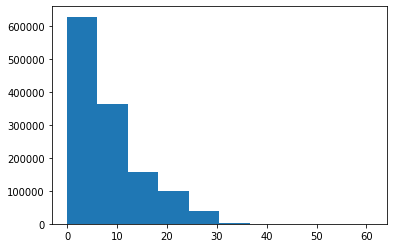

In [14]:
###Padding - checking for how to pad

list_len_Xt = [len(i) for i in X_train]
plt.hist(list_len_Xt)

In [15]:
X_train_pad = pad_sequences(X_train_token, dtype='float32', padding='post', maxlen=25)
X_test_pad = pad_sequences(X_test_token, dtype='float32', padding='post', maxlen=25)

In [16]:
embedding_size = 10

def initialize_model():
    
    model = Sequential()
    
    model.add(layers.Embedding(input_dim=vocab_size+1,output_dim=embedding_size, mask_zero=True, input_length=25))
    
    model.add(layers.LSTM(20))
    
    model.add(layers.Dense(10, activation='relu'))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                  metrics=['accuracy','Precision','Recall']
                 )
    return model

In [17]:
rnn = initialize_model()

rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 10)            4711400   
                                                                 
 lstm (LSTM)                 (None, 20)                2480      
                                                                 
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 4,714,101
Trainable params: 4,714,101
Non-trainable params: 0
_________________________________________________________________


In [19]:
###Model architecture works, but it would take ages to complete. Will export files to colab and try to run the model there

es = EarlyStopping(patience=5, restore_best_weights=True)

history = rnn.fit(X_train_pad, y_train, 
          epochs=500, 
          batch_size=64,
          validation_split=0.3,
          callbacks=[es]
         )

Epoch 1/500
14114/14114 [==============================] - 860s 60ms/step - loss: 0.3271 - accuracy: 0.8872 - precision: 0.7899 - recall: 0.2237 - val_loss: 0.3044 - val_accuracy: 0.8958 - val_precision: 0.8322 - val_recall: 0.2811
Epoch 2/500
14114/14114 [==============================] - 849s 60ms/step - loss: 0.2713 - accuracy: 0.9067 - precision: 0.8370 - recall: 0.3828 - val_loss: 0.3022 - val_accuracy: 0.8971 - val_precision: 0.7576 - val_recall: 0.3440
Epoch 3/500
14114/14114 [==============================] - 833s 59ms/step - loss: 0.2308 - accuracy: 0.9232 - precision: 0.8754 - recall: 0.5019 - val_loss: 0.3215 - val_accuracy: 0.8882 - val_precision: 0.6363 - val_recall: 0.3928
Epoch 4/500
14114/14114 [==============================] - 837s 59ms/step - loss: 0.2056 - accuracy: 0.9326 - precision: 0.9082 - recall: 0.5567 - val_loss: 0.3404 - val_accuracy: 0.8814 - val_precision: 0.5817 - val_recall: 0.4183
Epoch 5/500
14114/14114 [==============================] - 830s 59ms/ste

In [21]:
rnn.evaluate(X_test_pad, y_test)

10082/10082 [==============================] - 92s 9ms/step - loss: 0.3010 - accuracy: 0.8991 - precision: 0.8115 - recall: 0.3275


[0.3010481297969818, 0.899127721786499, 0.8114669919013977, 0.3275286853313446]